In [1]:
import pandas as pd
import ast 
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
import re
from transformers import pipeline


In [2]:
data = pd.read_csv("../data/processed/notes_2024_fqdn_selected.csv")
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn_selected"] = data["fqdn_selected"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]"
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]"
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]"
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com]
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com]


## Measurement of Factuality

In [3]:
node_status_count = defaultdict(lambda: {"helpful": 0, "not_helpful": 0})

for fqdn_set, status in zip(data["fqdn_selected"], data["currentStatus"]):
    for fqdn in set(fqdn_set):  
        if status == "CURRENTLY_RATED_HELPFUL":
            node_status_count[fqdn]["helpful"] += 1
        elif status == "CURRENTLY_RATED_NOT_HELPFUL":
            node_status_count[fqdn]["not_helpful"] += 1

# DataFrame化
df_nodes = pd.DataFrame([
    {
        "fqdn": fqdn,
        "helpful": counts["helpful"],
        "not_helpful": counts["not_helpful"],
        "total": counts["helpful"] + counts["not_helpful"],
        "helpful_ratio": counts["helpful"] / (counts["helpful"] + counts["not_helpful"]) if (counts["helpful"] + counts["not_helpful"]) > 0 else None
    }
    for fqdn, counts in node_status_count.items()
])

df_nodes = df_nodes.sort_values(by = "total", ascending= False)
df_nodes.head(5)

,fqdn,helpful,not_helpful,total,helpful_ratio
9,x.com,565,223,788,0.717005
18,en.m.wikipedia.org,107,151,258,0.414729
22,www.youtube.com,199,54,253,0.786561
3,www.reuters.com,206,28,234,0.880342
5,apnews.com,136,61,197,0.690355


In [4]:
def bootstrap_helpful_sign(data_list, n_bootstrap=10000, alpha=0.05):
    n = len(data_list)
    if n == 0:
        return np.nan, np.nan, np.nan
    
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data_list, size=n, replace=True)
        boot_means.append(np.mean(sample))
    
    lower = np.percentile(boot_means, 100 * (alpha/2))
    upper = np.percentile(boot_means, 100 * (1 - alpha/2))
    mean = np.mean(boot_means)
    return mean, lower, upper

means = []
lowers = []
uppers = []
labels = []

for idx, row in df_nodes.iterrows():
    data_list = [1] * int(row["helpful"]) + [-1] * int(row["not_helpful"])
    mean, lower, upper = bootstrap_helpful_sign(data_list)
    
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)
    labels.append(idx)

df_nodes["mean"] = means
df_nodes["ci_lower"] = lowers
df_nodes["ci_upper"] = uppers

df_nodes.to_csv("../data/processed/helpful_score.csv", index=False, header=True)
df_nodes.head()

,fqdn,helpful,not_helpful,total,helpful_ratio,mean,ci_lower,ci_upper
9,x.com,565,223,788,0.717005,0.434421,0.370558,0.497462
18,en.m.wikipedia.org,107,151,258,0.414729,-0.170453,-0.286822,-0.054264
22,www.youtube.com,199,54,253,0.786561,0.573131,0.470356,0.667984
3,www.reuters.com,206,28,234,0.880342,0.761036,0.675214,0.846154
5,apnews.com,136,61,197,0.690355,0.381023,0.258883,0.512690


In [9]:
df_nodes

,fqdn,helpful,not_helpful,total,helpful_ratio,mean,ci_lower,ci_upper,helpful_class
9,X (formerly Twitter),565,223,788,0.717005,0.434421,0.370558,0.497462,helpful
18,Wikipedia,107,151,258,0.414729,-0.170453,-0.286822,-0.054264,not_helpful
22,YouTube,199,54,253,0.786561,0.573131,0.470356,0.667984,helpful
3,Reuters,206,28,234,0.880342,0.761036,0.675214,0.846154,helpful
5,AP News,136,61,197,0.690355,0.381023,0.258883,0.512690,helpful
19,CNN,96,70,166,0.578313,0.156304,0.000000,0.301205,uncertain
16,NBC News,90,43,133,0.676692,0.352737,0.187970,0.503759,helpful
1,Newsweek,105,25,130,0.807692,0.614666,0.476923,0.738462,helpful
12,New York Times,80,49,129,0.620155,0.239829,0.069767,0.410853,helpful
14,USA Today,97,17,114,0.850877,0.700521,0.561404,0.824561,helpful


In [6]:
domain_to_name = {
    'www.google.com': 'Google',
    'nypost.com': 'New York Post',
    'www.msn.com': 'MSN',
    'www.axios.com': 'Axios',
    'truthsocial.com': 'Truth Social',
    'thehill.com': 'The Hill',
    'www.dailymail.co.uk': 'Daily Mail',
    'x.com': 'X (formerly Twitter)',
    'www.foxnews.com': 'Fox News',
    'www.npr.org': 'NPR',
    'en.m.wikipedia.org': 'Wikipedia',
    'www.cnn.com': 'CNN',
    'www.cbsnews.com': 'CBS News',
    'www.nytimes.com': 'New York Times',
    'www.pbs.org': 'PBS',
    'www.washingtonpost.com': 'Washington Post',
    'www.whitehouse.gov': 'White House',
    'abcnews.go.com': 'ABC News',
    'www.usatoday.com': 'USA Today',
    'apnews.com': 'AP News',
    'www.nbcnews.com': 'NBC News',
    'www.newsweek.com': 'Newsweek',
    'www.politico.com': 'Politico',
    'www.forbes.com': 'Forbes',
    'www.bbc.com': 'BBC',
    'www.theguardian.com': 'The Guardian',
    'www.donaldjtrump.com': 'Donald J. Trump',
    'www.independent.co.uk': 'The Independent',
    'www.reuters.com': 'Reuters',
    'www.politifact.com': 'PolitiFact',
    'www.youtube.com': 'YouTube',
    'www.yahoo.com': 'Yahoo',
    'www.factcheck.org': 'FactCheck.org',
    'www.snopes.com': 'Snopes',
    'www.instagram.com': 'Instagram',
    'www.gettyimages.com': 'Getty Images',
}

df_nodes["fqdn"] = df_nodes["fqdn"].map(domain_to_name)

In [7]:
df_nodes["helpful_class"] = "uncertain"

for i in range(len(df_nodes)):
    if df_nodes["ci_lower"].iloc[i] > 0:
        df_nodes["helpful_class"].iloc[i] = "helpful"
    elif df_nodes["ci_upper"].iloc[i] < 0:
        df_nodes["helpful_class"].iloc[i] = "not_helpful"

/var/folders/jb/b4wvvt9948bgtf9ccsyfxvlc0000gn/T/ipykernel_46933/1916214078.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_nodes["helpful_class"].iloc[i] = "helpful"
/var/folders/jb/b4wvvt9948bgtf9ccsyfxvlc0000gn/T/ipykernel_46933/19

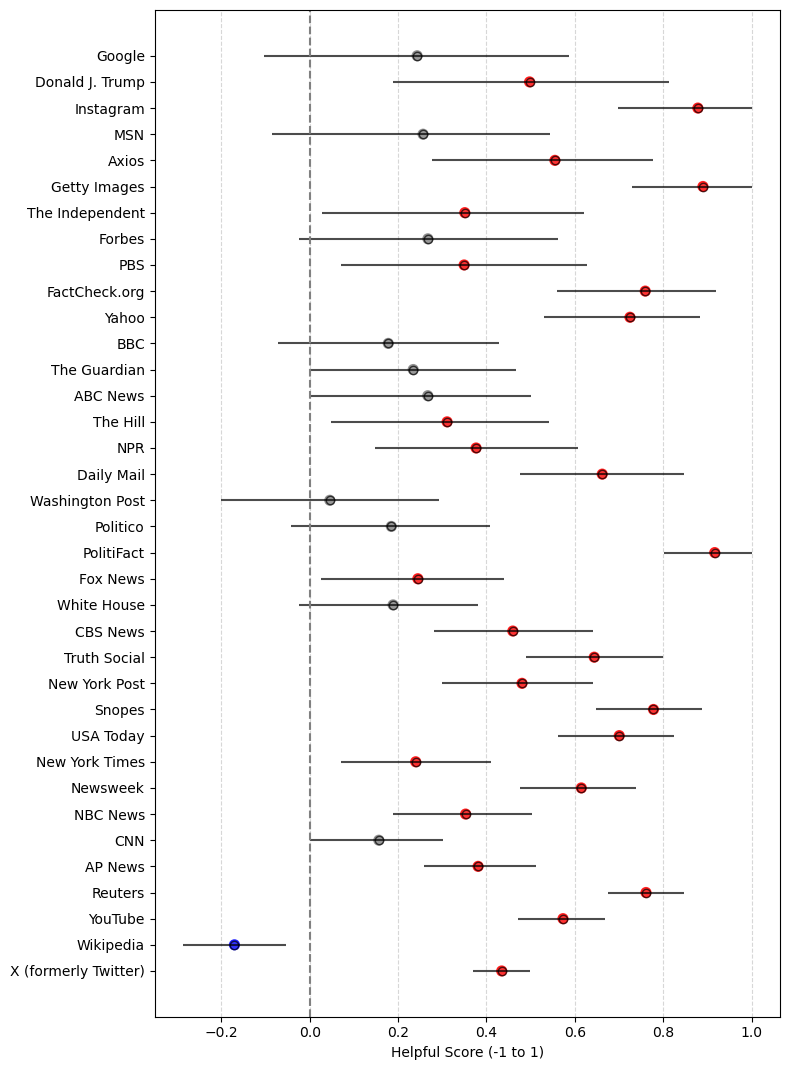

In [10]:
# set color by helpful_class
colors = df_nodes["helpful_class"].map({"helpful": "red", "not_helpful": "blue", "uncertain": "gray"})
medias = df_nodes["fqdn"].unique()
fig, ax = plt.subplots(figsize=(8, len(medias) * 0.3))


# draw error bars
plt.errorbar(
    df_nodes["mean"], df_nodes["fqdn"],
    xerr=[df_nodes["mean"] - df_nodes["ci_lower"],
          df_nodes["ci_upper"] - df_nodes["mean"]],
    fmt='o',  
    ecolor='black', 
    alpha=0.7,
    markerfacecolor='none',
    markeredgecolor='black'
)

# change color based on helpful_class
plt.scatter(df_nodes["mean"], df_nodes["fqdn"], color=colors, s=50, alpha=0.8)

# y axis : fqdn
plt.yticks(df_nodes["fqdn"], df_nodes["fqdn"])

plt.xlabel("Helpful Score (-1 to 1)")
#plt.title("Media Factuality with 95% Confidence Intervals")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--') 

plt.tight_layout()
fig.savefig("../figure/figure1.pdf", dpi=300)
plt.show()

In [11]:
helpful_selected = ["Wikipedia", "Instagram", "Getty Images", "Snopes", "PolitiFact", "FactCheck.org", "Truth Social", "X (formerly Twitter)", "Yahoo", "BBC", "Fox News", "NPR", "Washington Post", "CBS News", "USA Today", "New York Times", "NBC News", "CNN"]
df_nodes = df_nodes[df_nodes["fqdn"].isin(helpful_selected)]
df_nodes

,fqdn,helpful,not_helpful,total,helpful_ratio,mean,ci_lower,ci_upper,helpful_class
9,X (formerly Twitter),565,223,788,0.717005,0.434421,0.370558,0.497462,helpful
18,Wikipedia,107,151,258,0.414729,-0.170453,-0.286822,-0.054264,not_helpful
19,CNN,96,70,166,0.578313,0.156304,0.000000,0.301205,uncertain
16,NBC News,90,43,133,0.676692,0.352737,0.187970,0.503759,helpful
12,New York Times,80,49,129,0.620155,0.239829,0.069767,0.410853,helpful
14,USA Today,97,17,114,0.850877,0.700521,0.561404,0.824561,helpful
10,Snopes,96,12,108,0.888889,0.777998,0.648148,0.888889,helpful
0,Truth Social,74,16,90,0.822222,0.643851,0.488889,0.800000,helpful
11,CBS News,65,24,89,0.730337,0.459578,0.280899,0.640449,helpful
20,Fox News,51,31,82,0.621951,0.244700,0.024390,0.439024,helpful


## Measurement of Bias

In [8]:
# before NLP, I need to filter out URLs from the summary
data["summary_filtered"] = data["summary"].apply(lambda x: re.sub(r'https://\S+', '', x))

In [9]:
# use a model of "matous-volf/political-leaning-deberta-large"
pipe = pipeline(
    "text-classification",
    model="matous-volf/political-leaning-deberta-large",
    tokenizer="microsoft/deberta-v3-large",
)


data["classification_result"] = data["summary_filtered"].apply(lambda x: pipe(x))

data[["classification_result"]]

/opt/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use mps:0


In [ ]:
data["classification_label"] = data["classification_result"].apply(lambda x: x[0]["label"])
data["classification_score"] = data["classification_result"].apply(lambda x: x[0]["score"])
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected,summary_filtered,classification_result,classification_label,classification_score
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]",Trump posted on Truth Social on 12/30/2023 tha...,"[{'label': 'LABEL_2', 'score': 0.9998847246170...",LABEL_2,0.999885
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]",This has been refuted multiple times as false....,"[{'label': 'LABEL_2', 'score': 0.9996803998947...",LABEL_2,0.999680
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","This story was updated, originally reporting t...","[{'label': 'LABEL_0', 'score': 0.9895700216293...",LABEL_0,0.989570
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com],This is not true. Joe Biden led the 2020 Democ...,"[{'label': 'LABEL_0', 'score': 0.9997561573982...",LABEL_0,0.999756
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com],Author has posted a selectively edited photo o...,"[{'label': 'LABEL_2', 'score': 0.9644505977630...",LABEL_2,0.964451


In [ ]:
data.to_csv("../data/processed/notes_2024_fqdn_selected_with_classification.csv", index=False)

In [12]:
data = pd.read_csv("../data/processed/notes_2024_fqdn_selected_with_classification.csv")
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn_selected"] = data["fqdn_selected"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected,summary_filtered,classification_result,classification_label,classification_score
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]",Trump posted on Truth Social on 12/30/2023 tha...,"[{'label': 'LABEL_2', 'score': 0.9998847246170...",LABEL_2,0.999885
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]",This has been refuted multiple times as false....,"[{'label': 'LABEL_2', 'score': 0.9996803998947...",LABEL_2,0.999680
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","This story was updated, originally reporting t...","[{'label': 'LABEL_0', 'score': 0.9895700216293...",LABEL_0,0.989570
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com],This is not true. Joe Biden led the 2020 Democ...,"[{'label': 'LABEL_0', 'score': 0.9997561573982...",LABEL_0,0.999756
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com],Author has posted a selectively edited photo o...,"[{'label': 'LABEL_2', 'score': 0.9644505977630...",LABEL_2,0.964451


In [13]:
expanded = data.explode('fqdn_selected')[['classification_label', 'fqdn_selected']]

# count occurrences of each label and fqdn
counts = expanded.value_counts().reset_index(name='count')

counts.columns = ['classification_label', 'fqdn', 'count']

# replace classification labels with more readable names
counts = counts.replace({"LABEL_2": "Right", "LABEL_1" : "Center", "LABEL_0" : "Left"})

counts.head()

,classification_label,fqdn,count
0,Right,x.com,542
1,Left,x.com,466
2,Left,www.youtube.com,163
3,Left,en.m.wikipedia.org,141
4,Left,www.reuters.com,135


In [14]:
pivot_df = counts.pivot_table(
    index="fqdn",
    columns="classification_label",
    values="count",
    aggfunc="sum",
    fill_value=0
)

counts_media = pivot_df[["Left", "Center", "Right"]]

counts_media = counts_media.reset_index()

counts_media.index = counts_media["fqdn"]
counts_media = counts_media.drop(columns = "fqdn")
counts_media["total"] = counts_media["Left"] + counts_media["Center"] + counts_media["Right"]
counts_media = counts_media.sort_values("total", ascending = False)
counts_media.head()

classification_label,Left,Center,Right,total
fqdn,,,,
x.com,466,42,542,1050
en.m.wikipedia.org,141,25,133,299
www.youtube.com,163,20,95,278
www.reuters.com,135,19,85,239
apnews.com,102,14,82,198


In [15]:
medias = set([m for sublist in data["fqdn_selected"] for m in sublist])
labels_map = {"LABEL_0": -1, "LABEL_1": 0, "LABEL_2": 1}

results = {}

for media in medias:

    indices = [i for i, domains in enumerate(data["fqdn_selected"]) if media in domains]
    if not indices:
        continue
    

    media_labels = [labels_map[data["classification_label"][i]] for i in indices]


    boot_means = []
    for _ in range(10000):
        sample = np.random.choice(media_labels, size=len(media_labels), replace=True)
        boot_means.append(np.mean(sample))

    mean_score = np.mean(boot_means)
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)

    results[media] = {"mean": mean_score, "ci_lower": ci_lower, "ci_upper": ci_upper}

results = pd.DataFrame(results)
results = results.T
results = results.sort_values("mean")
results.head()

,mean,ci_lower,ci_upper
www.gettyimages.com,-0.540403,-0.783784,-0.270270
www.instagram.com,-0.394612,-0.696970,-0.090909
www.snopes.com,-0.314721,-0.481481,-0.138889
www.factcheck.org,-0.280516,-0.520000,-0.020000
www.yahoo.com,-0.274778,-0.529412,-0.019608


In [16]:
results = pd.concat([results, counts_media], axis=1)
results.to_csv("../data/processed/media_bias_score.csv", index=True, header=True)
results.head()

,mean,ci_lower,ci_upper,Left,Center,Right,total
www.gettyimages.com,-0.540403,-0.783784,-0.270270,31,1,8,40
www.instagram.com,-0.394612,-0.696970,-0.090909,27,0,10,37
www.snopes.com,-0.314721,-0.481481,-0.138889,67,8,34,109
www.factcheck.org,-0.280516,-0.520000,-0.020000,30,4,16,50
www.yahoo.com,-0.274778,-0.529412,-0.019608,31,3,17,51


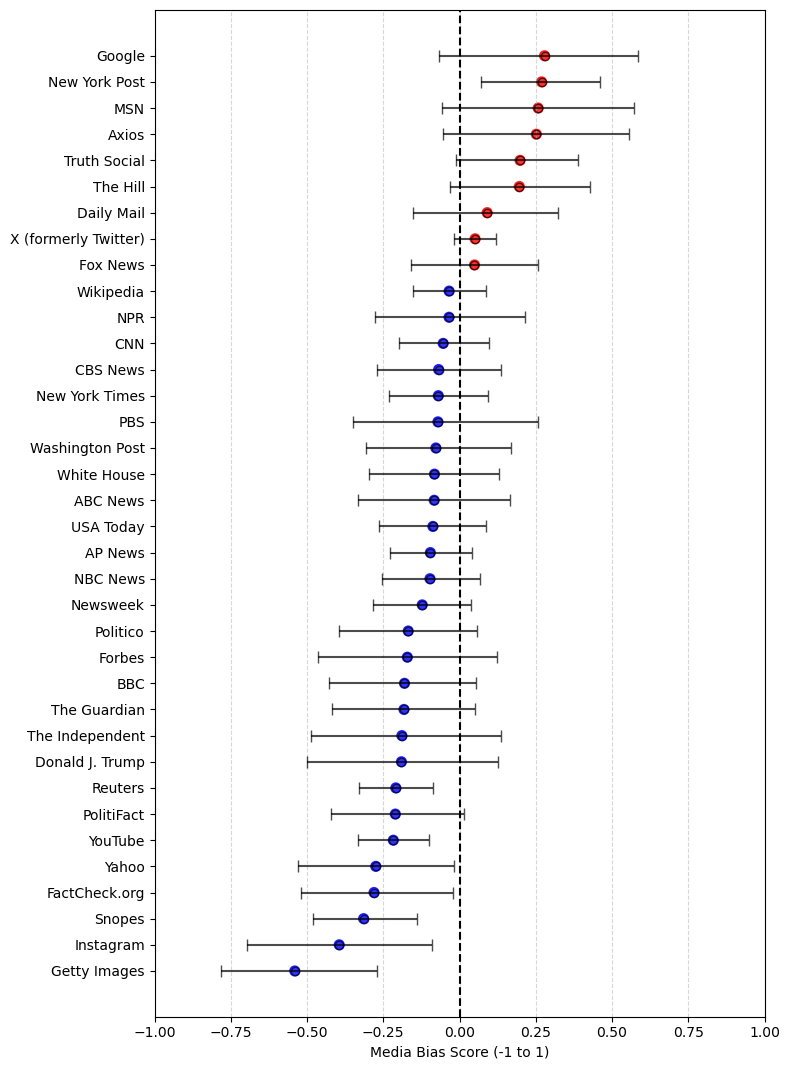

In [17]:
results.index = results.index.map(domain_to_name)


colors = results["mean"].apply(lambda x: "red" if x > 0 else ("blue" if x < 0 else "gray"))
medias = results.index
fig, ax = plt.subplots(figsize=(8, len(medias) * 0.3))

#draw error bars
plt.errorbar(
    results["mean"], results.index,
    xerr = [results["mean"] - results["ci_lower"], 
           results["ci_upper"] - results["mean"]],
    fmt ='o',
    ecolor='black',
    alpha=0.7,
    markerfacecolor = 'none',
    markeredgecolor = 'black',
    capsize = 4
)

# change color based on mean
plt.scatter(results["mean"], results.index, color=colors, s=50, alpha=0.8)

# y axis : fqdn
plt.yticks(results.index, results.index)

plt.xlim(-1, 1)
plt.xlabel("Media Bias Score (-1 to 1)")
#plt.title("Media Bias with 95% Confidence Intervals")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', label='Center (0)')
plt.tight_layout()
fig.savefig("../figure/figure2.pdf", dpi=300)
plt.show()

In [ ]:
mediabias_selected = ["Google", "New York Post", "Fox News", "Truth Social", "X (formerly Twitter)", "FactCheck.org", "Snopes", "PolitiFact", "CNN","New York Times", "PBS", "YouTube", "Instagram", "Getty Images"]

In [ ]:
results = results.loc[results.index.isin(mediabias_selected)]
results

,mean,ci_lower,ci_upper,Left,Center,Right,total
Getty Images,-0.540459,-0.783784,-0.270270,31,1,8,40
Instagram,-0.395103,-0.696970,-0.090909,27,0,10,37
Snopes,-0.315218,-0.481481,-0.138889,67,8,34,109
FactCheck.org,-0.281778,-0.520000,-0.020000,30,4,16,50
YouTube,-0.217371,-0.332016,-0.102767,163,20,95,278
PolitiFact,-0.209035,-0.422535,0.014085,41,6,28,75
PBS,-0.072009,-0.348837,0.209302,24,0,20,44
New York Times,-0.067888,-0.224806,0.093023,63,13,59,135
CNN,-0.053898,-0.198795,0.090512,95,9,86,190
Fox News,0.048255,-0.170732,0.268293,42,2,43,87
